### Summary

&emsp; This notebook shows the classification performance of two different types of models (logisitc regression and a Recursive Neural Networks).

&emsp; The folder containing this notebook is expected to contain a utils.py script (containing custom functions for data wrangling and analysis) and the EMG_data folder (downloaded from: http://archive.ics.uci.edu/ml/datasets/EMG+data+for+gestures#)

In [1]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#load custon functions
from EMG_gestures.utils import *
from EMG_gestures.analysis import within_subject_nn_performance, within_subject_rnn_performance

Using TensorFlow backend.


### Signal Features

&emsp; Extracting features from the input signal is a crucial step in any classification problem. Two different types of features can be computed for time-series data: 1) time-domain (TD) features and 2) frequency-domain (FD) features. Spiewak et al., (2018) summarize vaious features that can be used to characterize EMG signals. Any of these, in isolation or combination, could be helpful for the problem of gesutre classification at hand. 
Thankfully, Osokei & Hu (2008) conducted a systematic study of various TD and FD features for the purpose of decoding upper limb positions from EMG data. The authors find two TD features that are most informative about upper limb movements: Mean Absolute Value (MAV) and Wavelength (WL). Moreover, the authors find that performance of an SVM classifier is optimized when these features are computed over non-overlapping segments of the data 200 ms in length. 


&emsp; I leveraged the results as a starting off point for the task of classifying upper limb gestures from the EMG data in this data set. It's possible that these features are deficient in some way (e.g., not robust to different subjects or limited in the types of movements that can be decoded from them). Therefore, an obvious extension of the work presented here would be to see if features other than the ones used here provide more robust clasification model. 

&emsp; The code block below loads, preprocesses, and computes the features over all collected data for a given subject. 

In [2]:
# Process data and get features 

#define where the data file are located
subject_id = 28
data_folder = '../EMG_data/%02d'%(subject_id)

# Processing pipeline
# 1) Re-sample timeseries to steady sampling rate
# 2) Bandpass filter
# 3) Segment data into 200 ms segments (exclude segments with more than 1 label)
# 4) Compute features in each segment

# User-defined parameters

lo_freq = 20 #lower bound of bandpass filter
hi_freq = 450 #upper bound of bandpass filter

win_size = 200 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case we want to re-run later with some overlap

feature_matrix, target_labels, window_tstamps, \
block_labels, series_labels = get_subject_data_for_classification(data_folder, lo_freq, hi_freq, \
                                                                  win_size, step)

# resulting feature_matrix has dimension [nsamples, nfeatures]

nsamples, nfeat = feature_matrix.shape
print(feature_matrix.shape)

(483, 16)


&emsp; Before feeding the data into a classifier function, it's useful to know the distribution of sample counts for each class. Having a heavily over-represented class can lead to a biased estimate of model performance since the cost function can be minimized by always classifying as the majority class. 

&emsp; The table and plot plot below shows the sample count for each class

   Target Labels  Value Count
0              1           25
1              2           26
2              3           27
3              4           27
4              5           25
5              6           29


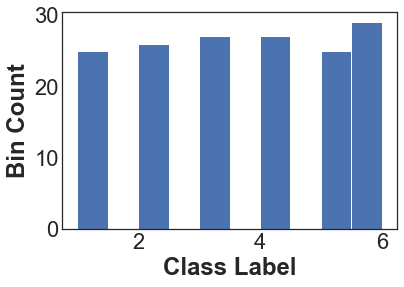

In [3]:
#exclude unlabeled data
in_samples = np.where(target_labels != 0)[0]
feature_matrix_in = feature_matrix[in_samples,:]
target_labels_in = target_labels[in_samples]

#show histogram for target labels
plt.hist(target_labels_in.astype('int'))
plt.xlabel('Class Label');
plt.ylabel('Bin Count');

#Display bin count values as well
y = np.bincount(target_labels_in.astype('int'))
ii = np.nonzero(y)[0]
print(pd.DataFrame(np.vstack((ii,y[ii])).T,columns = ['Target Labels','Value Count']))

**Observations:** As can be seen, the samples are roughly balanced. The mismatch in samples is not great enough to be an issue. However, in this context an F1 measure will be superior to accuracy in assesing classifier performance. 

&emsp; Before going on to build the classification model, it's also useful to examine the similarity of samples from different classes. This can give an idea of whether there's actually some structure in the data the classifier has a chance of finding. Below I perform a dimensionality reduction and visualize the results. tSNE was best at revealing the structure of the data. 

Data are labelled according to the following convention
+ 0 - unmarked data,
+ 1 - hand at rest, 
+ 2 - hand clenched in a fist, 
+ 3 - wrist flexion,
+ 4 – wrist extension,
+ 5 – radial deviations,
+ 6 - ulnar deviations,
+ 7 - extended palm (not performed by all subjects).

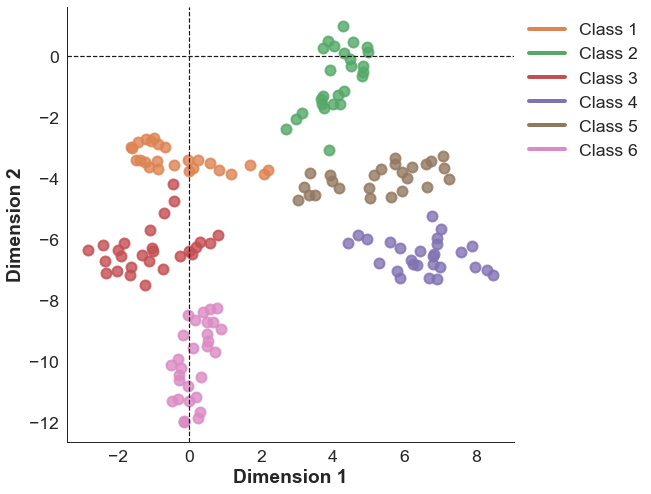

In [4]:
#tsne
np.random.seed(42)#to replicate stochastic aspect of dimensionality recution
fig = dim_reduction_visualization(feature_matrix_in, target_labels_in)

**Observations:** The scatter plots above show the low-dimensionality embedding for each of the labeled segments in the data ussed to train and evaluate the classifier. Dot color depicts the class of the sample. As can be seen, the samples mostly cluster according to the class to which they belong to, which means there's some meaningul structure in the data that the classifier can find. Some degree of overlap may be due to the difficulty in embedding the high-dimensional feature space into just two dimensions.


&emsp; The code block below trains and evaluates a simple single-layer neural network to classify upper-limb gestures from the pattern of signals across electrodes. In order to put the performance in context, it's useful to also measure classifier performance after randomly shuffling the class labels (i.e., erasing the relationship between signal and class).

Some details on data preparation and the model
+ Values are standardized across samples within each feature dimension
+ Neural network is regularized with a single dropout layer
+ Using categorical cross-entropy for loss function
+ Using an early stopping scheme where we stop training epochs when the training and validation loss begin to diverge
+ Model performance is assesed on the held-out set with stratified k-fold cross-validation which keeps the class balance across train/test splits.

In [5]:
results_folder = '../results_data/single_subject_training/simple_NN/'
results_fn = 'subject_%02d_within_subject_results.h5'%(subject_id,)

#load if, file exists, otherwise generate
if os.path.exists(os.path.join(results_folder,results_fn)):
    nn_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
else:
    # Train and evaluate neural network classifier 

    # Initialize empty lists
    nn_results_df = []
    prob_class = np.empty((0,0,0))

    # Set seed for replicability
    np.random.seed(1)

    model_dict = {'fe_layers':1,'fe_activation':'tanh'}
    # Repeat analysis over multiple repetitions to take into account stochasticity of experiment
    nreps = 10
    for rep in range(nreps):
        print('**Repetition %i'%(rep+1))
        print('---True Data---')
        
        # Feed data into function for training and evaluation
        train_f1, test_f1, prob_class_rep, train_info_dict = within_subject_nn_performance(feature_matrix, target_labels,\
                                                                                        series_labels,\
                                                                                        model_dict, batch_size = 2, es_patience = 5,
                                                                                        prob_output = True)
        
        nfolds, nscores = train_f1.shape
        # Put results in dataframe
        nn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(train_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                'Shuffled':[False for x in range(nfolds)],\
                                'Type':['Train' for x in range(nfolds)]}))
        
        nn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(test_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                'Shuffled':[False for x in range(nfolds)],\
                                'Type':['Test' for x in range(nfolds)]}))
        
        #concatenate class probabilities
        prob_class = np.dstack((prob_class, prob_class_rep)) if prob_class.size else prob_class_rep



    # Run classifier with shuffled data (null hypothesis)
    for rep in range(nreps):
        print('**Repetition %i'%(rep+1))
        print('---Permuted Data---')
        #train and evaluate a classifer shuffling the class labels
        train_f1, test_f1, dummy, train_info_dict = within_subject_nn_performance(feature_matrix, np.random.permutation(target_labels),\
                                                                series_labels,model_dict,es_patience = 5, prob_output = False)

        # Put results in dataframe
        nn_results_df.append(pd.DataFrame({'f1_score':np.squeeze(train_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                'Shuffled':[True for x in range(nfolds)],\
                                'Type':['Train' for x in range(nfolds)]}))
        
        nn_results_df.append(pd.DataFrame({'f1_score':np.squeeze(test_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                'Shuffled':[True for x in range(nfolds)],\
                                'Type':['Test' for x in range(nfolds)]}))
        
    #concatenate all dataframes
    nn_results_df = pd.concat(nn_results_df, axis =0)
    #save to file
    nn_results_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')


#average over folds
nn_results_df = nn_results_df.groupby(['Shuffled','Type','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(nn_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Rep']).to_html()))

#Compare real and null distributions. Output p-value

tstat, pval_test = scipy.stats.ttest_ind(nn_results_df.loc[(nn_results_df.Type == 'Test')&(nn_results_df.Shuffled == False)]['f1_score'].values,\
                                         nn_results_df.loc[(nn_results_df.Type == 'Test')&(nn_results_df.Shuffled == True)]['f1_score'].values)
print('Test performance pval: %E' %(pval_test))


Test performance pval: 2.736033E-16


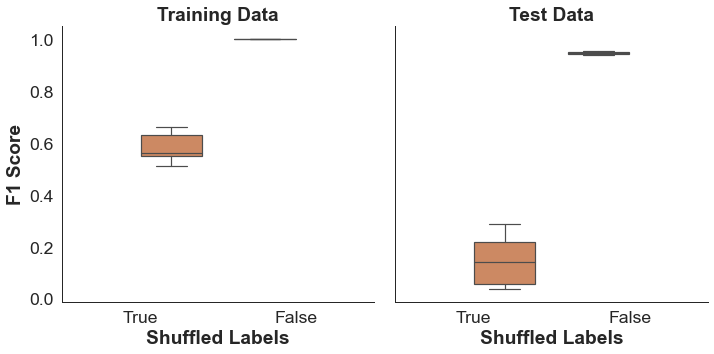

In [6]:

#Visualize results
g = sns.catplot(data = nn_results_df, x= 'Shuffled', y = 'f1_score', hue = 'Shuffled',\
            col = 'Type',kind = 'box', order = [True,False], col_order = ['Train','Test'])
#Label axes and subpots
for ax in g.axes[0]:
    ax.set_xlabel('Shuffled Labels')
g.axes[0][0].set_ylabel('F1 Score')
g.axes[0][0].set_title('Training Data',fontweight = 'bold');
g.axes[0][1].set_title('Test Data',fontweight = 'bold');

**Observations:**  The boxplots above show classifier performance for training and testing partitions of the data over multiple repetitions of the train/test splits. Results are shown for the actual data (blue) and shuffled-label data (yellow). I also display the p-value of the 2-sample t-tests comparinf the real and shuffled data distributions for the test performance.

&emsp; As can be seen test performance of the classifier is quite good (average F1 score is .95 for subject 28). One limitation of the above approach is that temporal information has been completely discarded because features from each data segment are treated independently. There are two approaches to actually make use of the temporal information in the data:

1) Add a 'majority voting' stage to the current model:  Below, I visualize the probability of each class over the whole acquisition period. The class probability within the labeled periods was inferred using held out data. From this plot we can see that neighboring timepoints tend to be classified to the same class. There are some periods where the classifier alternates between class label predictions. These periods could be 'smoothed out' by adding stage of the model where the final class label for each segment is decided based on the majority class labels for a small number neighboring of timepoints. This is a weak approach to incroporate the tempral stucture of the data into our model. 

2) Use a Recursive Neural Network (RNN) architecture: RNNs can leverage the history of patterns in a sequence to make predictions about future timepoints. RNNs can also be made bidirectional to take into account past and future time points, though this increases the number of parameters in the model. Results from this approach are explored further below.


Split Count: 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training Model
Evaluate Model
Split Count: 2
Training Model
Evaluate Model


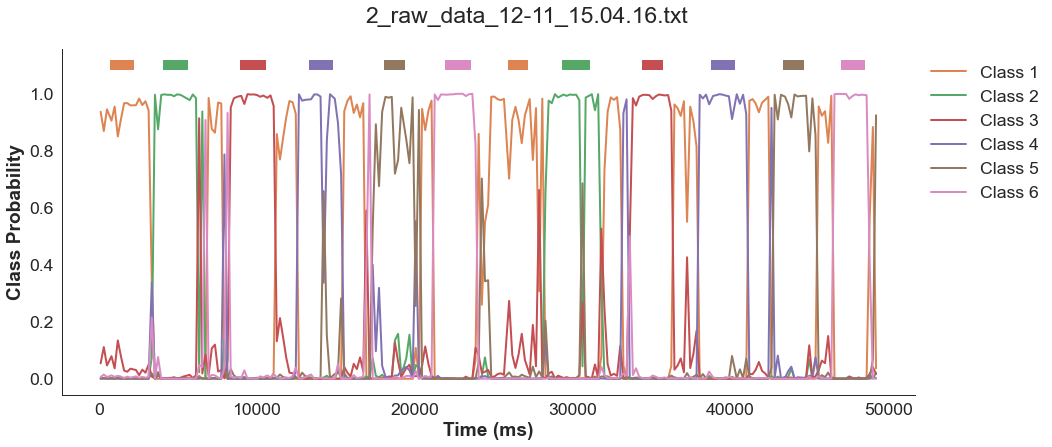

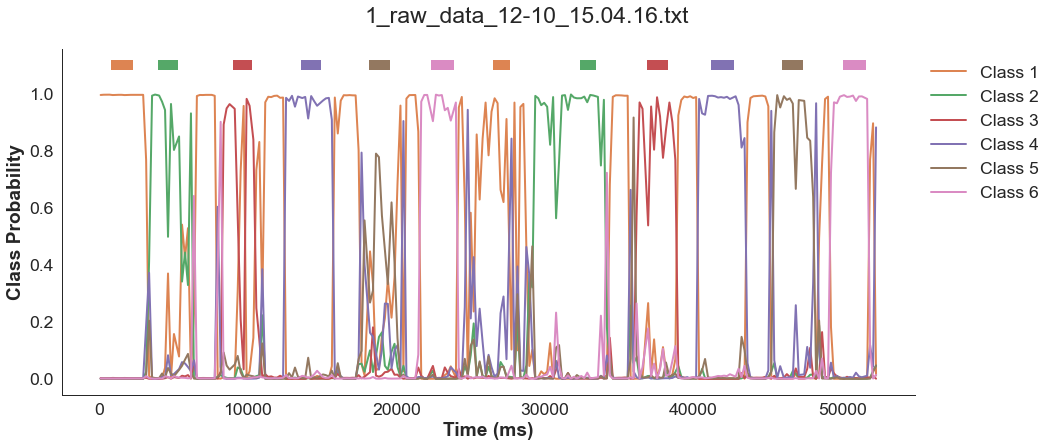

In [7]:
# run a single repetition of classifier training and cross-validation
model_dict = {'fe_layers':1,'fe_activation':'tanh'}
a, b, prob_class_rep, c = within_subject_nn_performance(feature_matrix, target_labels,\
                                                                                    series_labels,\
                                                                                    model_dict, batch_size = 2, es_patience = 5,
                                                                                    prob_output = True)
# visualize class probability over time.
fig = visualize_time_series_prob(data_folder, prob_class_rep, window_tstamps, series_labels)

**Observations:** The plots above also suggest that the 'unmarked' periods of the data correspond to transsitions between movements because the most probable class labels during these periods correspond to the labels from the adjacent labeled periods.

## 3. Limb Position Classification with Recursive Neural Network

As discussed above, the simple neural network approach has the limitation of not making use of temporal information in the data. Below, I use a relatively simple RNN to infer limb position from the patterns in the data across electrodes and across time. I focus on training and evaluating the model on blocks of data that have been fully labeled to avoid complications with the 'umarked' timepoints as discussed above. I use the same time-domain features used to train and evalute the single-layer network described above.

RNNs can have a large number of parameters so I made a couple of decisions given that there's only a small number of samples per subject (though it only took a couple of minutes to collect this data so much more data could be easily acquired). First, I opted to use Gated Recursive Units for my recursive layer. GRUs are less complex and have less paramters compared to the more widely used LSTMs, which makes them easier to train. I also made the decision to only include a small number of units in the GRU layer (24 units), again this reduces the number of parameters.

I also use a dropout layer in order to regularize the network and prevent overfitting.

Here's a schematic of the architecture for the model I use:

Input Layer -> GRU layer -> Droput -> Dense Layer -> softmax

In the code blocks below, I train and evaluate the model and present the results. These steps can take a while to run on a CPU. I recommend running this portion on Google Colab or a GPU-equipped workstation. If available, I simply load in the results.

In [8]:


win_size = 100 #define window size over which to compute time-domain features
step = win_size #keeping this parameter in case I want to re-run later with some overlap

#get features across segments and corresponding info
feature_matrix, target_labels, window_tstamps, \
block_labels, series_labels = get_subject_data_for_classification(data_folder, lo_freq, hi_freq, \
                                                                  win_size, step)

In [9]:
results_folder = '../results_data/single_subject_training/RNN/'
results_fn = 'subject_%02d_within_subject_results.h5'%(subject_id,)
#load if, file exists, otherwise generate
if os.path.exists(os.path.join(results_folder,results_fn)):
    rnn_results_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
else:
    win_size = 100 #define window size over which to compute time-domain features
    step = win_size #keeping this parameter in case I want to re-run later with some overlap

    #get features across segments and corresponding info
    feature_matrix, target_labels, window_tstamps, \
    block_labels, series_labels = get_subject_data_for_classification(data_folder, lo_freq, hi_freq, \
                                                                      win_size, step)

    #RNN training
    model_dict = {'fe_layers':1, 'fe_activation':'tanh'}

    #initialize empty list
    rnn_results_df = []

    # Set seed for replicability
    np.random.seed(1)

    # Repeat analysis over multiple repetitions to take into account stochasticity of experiment
    nreps = 10
    for rep in range(nreps):
        print('**Repetition %i'%(rep+1))
        print('---True Data---')

        #trained and evalute RNN model on labeled data
        train_f1, test_f1, train_info_dict = within_subject_rnn_performance(feature_matrix, target_labels, block_labels, series_labels,\
                                                           model_dict,exclude = [0])

        nfolds, nscores = train_f1.shape
        # Put results in dataframe
        rnn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(train_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                   'Shuffled':[False for x in range(nfolds)],\
                                   'Type':['Train' for x in range(nfolds)]}))

        rnn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(test_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                   'Shuffled':[False for x in range(nfolds)],\
                                   'Type':['Test' for x in range(nfolds)]}))


        print('---Permuted Data---')
        target_labels_perm = permute_class_within_sub(target_labels, block_labels,\
                                                      series_labels, exclude= [0])
        train_f1, test_f1, train_info_dict = within_subject_rnn_performance(feature_matrix, target_labels_perm, block_labels, series_labels,\
                                                           model_dict,exclude = [0])

        # Put results in dataframe
        rnn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(train_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                   'Shuffled':[True for x in range(nfolds)],\
                                   'Type':['Train' for x in range(nfolds)]}))

        rnn_results_df.append(pd.DataFrame({'F1_score':np.squeeze(test_f1),\
                                        'Rep':[rep+1 for x in range(nfolds)],\
                                        'Fold': np.arange(nfolds)+1,\
                                   'Shuffled':[True for x in range(nfolds)],\
                                   'Type':['Test' for x in range(nfolds)]}))

    #concatenate all dataframes
    rnn_results_df = pd.concat(rnn_results_df, axis =0)
    #save to file
    rnn_results_df.to_hdf(os.path.join(results_folder,results_fn), key='results_df', mode='w')
#average over folds
rnn_results_df = rnn_results_df.groupby(['Shuffled','Type','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Epochs','Batch_Size','Train_Loss','Val_Loss'])

# Output summary
display(HTML(rnn_results_df.groupby(['Shuffled','Type']).mean().drop(columns = ['Rep']).to_html()))

#Compare real and null distributions. Output p-value

tstat, pval_test = scipy.stats.ttest_ind(rnn_results_df.loc[(rnn_results_df.Type == 'Test')&(rnn_results_df.Shuffled == False)]['f1_score'].values,\
                                         rnn_results_df.loc[(rnn_results_df.Type == 'Test')&(rnn_results_df.Shuffled == True)]['f1_score'].values)
print('Test performance pval: %E' %(pval_test))

Test performance pval: 3.451051E-19


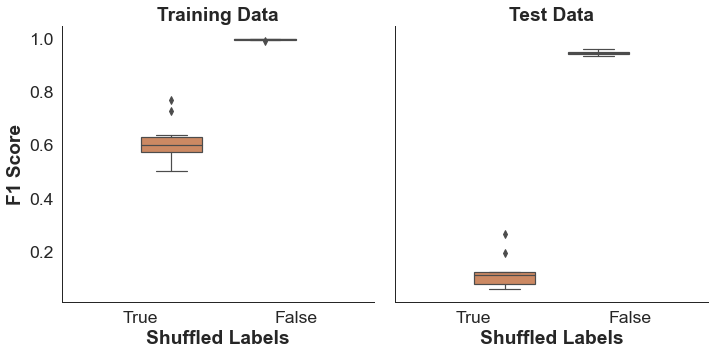

In [10]:
#Visualize results
g = sns.catplot(data = rnn_results_df, x= 'Shuffled', y = 'f1_score', hue = 'Shuffled',\
            col = 'Type',kind = 'box', order = [True,False], col_order = ['Train','Test'])
#Label axes and subpots
for ax in g.axes[0]:
    ax.set_xlabel('Shuffled Labels')
g.axes[0][0].set_ylabel('F1 Score')
g.axes[0][0].set_title('Training Data',fontweight = 'bold');
g.axes[0][1].set_title('Test Data',fontweight = 'bold');

The boxplots above show classifier performance for training and testing partitions of the data over multiple repetitions of the train/test splits. Results are shown for the actual data (blue) and shuffled-label data (yellow). I also display the p-value of the 2-sample t-tests comparing the real and shuffled data distributions for the test performance.


**Observations:** Model performance on the test set is quite good (~.94 F1 score for subject 28). Below, I compare performance on held-out data of both the single-layer neural network and RNN classifier model.


Model comparison pval: 7.768330E-01


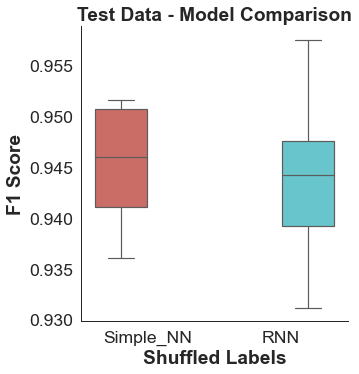

In [11]:
nn_results_df['Model'] = 'Simple_NN'
rnn_results_df['Model'] = 'RNN'

all_results_df = pd.concat([nn_results_df,rnn_results_df],axis = 0)

test_results_df = all_results_df.loc[(all_results_df.Type == 'Test')&\
                                     (all_results_df.Shuffled == False)]



#Compare across models. Output p-value

tstat, pval_model = scipy.stats.ttest_ind(test_results_df.loc[(test_results_df.Model == 'Simple_NN')]['f1_score'].values,\
                                        test_results_df.loc[(test_results_df.Model == 'RNN')]['f1_score'].values)
print('Model comparison pval: %E' %(pval_model))

#Visualize results
sns.set_palette(sns.color_palette("hls", 2))
g = sns.catplot(data = test_results_df, x= 'Model', y = 'f1_score', hue = 'Model',\
            kind = 'box', order = ['Simple_NN','RNN'])
#Label axes and subpots
for ax in g.axes[0]:
    ax.set_xlabel('Shuffled Labels')
g.axes[0][0].set_ylabel('F1 Score')
g.axes[0][0].set_title('Test Data - Model Comparison',fontweight = 'bold');



**Observations:** As can be seen, test classifier performance is not statistically different between the two types of models (p=.78). This suggests that there is little temporal informaition in the data that the RNN model could take advantage of. This is likely due to the fact that the classification task is to identity static limb gestures from the time series data rather than a more more dynamic gestures such as hand-waving vs. finger-snapping.

Though looking at data from a single subject can be useful, it is best to perform this comparison across multiple subjects. In another notebook, I look at model performance within and across subjects using data from multiple subjects. 
